# Install Libraries

In [186]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os



# Modeling

In [187]:
X_train = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_train_baseline.parquet.parquet')
X_test  = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_test_baseline.parquet.parquet')
y_train = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/y_train.parquet.parquet')

In [188]:
numeric_features = ['distance', 'passenger_count', 'pickup_hour', 'pickup_dayofweek', 'is_rest_day']
categorical_features = ['vendor_id', 'store_and_fwd_flag']

In [189]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)

In [190]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.float32)  # regression

In [191]:
def to_tensor(x) :
    
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    
    preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

    x_processed = preprocessor.fit_transform(x)
    x_tensor = torch.tensor(x_processed, dtype=torch.float32)
    return x_tensor


In [192]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train_tensor, y_train_tensor)


In [193]:
def rmsle(y_true, y_pred):
    """
    Computes Root Mean Squared Logarithmic Error
    y_true and y_pred should be non-negative
    """
    # Ensure predictions are >= 0 to avoid log issues
    y_pred = np.maximum(y_pred, 0)
    y_true = np.maximum(y_true, 0)
    
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


# FFNN

## Baseline Model

In [194]:
class FFNN_simple(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [195]:
class FFNN_complex(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [196]:
## 2 Hidden Layer FFNN ##
model = FFNN_simple(input_size=X_train_tensor.shape[1], output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
all_epochs_results = []

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE": rmsle_val
    }
    
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | "
          f"R²: {r2:.4f} | RMSLE: {rmsle_val:.4f}")

baseline_two_layer_results = all_epochs_results

## 4 Hidden Layer FFNN ## 
model = FFNN_complex(input_size=X_train_tensor.shape[1], output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
all_epochs_results = []

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE": rmsle_val
    }
    
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | "
          f"R²: {r2:.4f} | RMSLE: {rmsle_val:.4f}")
    
baseline_four_layer_results = all_epochs_results


Epoch 1 | Loss: 27195850.4221 | MSE: 27196070.0000 | RMSE: 5214.9851 | MAE: 466.7344 | R²: 0.0086 | RMSLE: 0.8253
Epoch 2 | Loss: 27178772.7738 | MSE: 27178994.0000 | RMSE: 5213.3477 | MAE: 456.8171 | R²: 0.0092 | RMSLE: 0.6672
Epoch 3 | Loss: 27175933.2201 | MSE: 27176154.0000 | RMSE: 5213.0753 | MAE: 456.9445 | R²: 0.0093 | RMSLE: 0.6685
Epoch 4 | Loss: 27174645.1256 | MSE: 27174866.0000 | RMSE: 5212.9518 | MAE: 457.2849 | R²: 0.0093 | RMSLE: 0.6694
Epoch 5 | Loss: 27173653.3308 | MSE: 27173874.0000 | RMSE: 5212.8566 | MAE: 457.1967 | R²: 0.0094 | RMSLE: 0.6686
Epoch 1 | Loss: 27210462.1702 | MSE: 27210682.0000 | RMSE: 5216.3859 | MAE: 477.0518 | R²: 0.0080 | RMSLE: 1.2103
Epoch 2 | Loss: 27150642.3836 | MSE: 27150864.0000 | RMSE: 5210.6491 | MAE: 445.3696 | R²: 0.0102 | RMSLE: 0.6451
Epoch 3 | Loss: 27125649.3934 | MSE: 27122894.0000 | RMSE: 5207.9645 | MAE: 429.0681 | R²: 0.0112 | RMSLE: 0.6009
Epoch 4 | Loss: 27113538.3669 | MSE: 27113762.0000 | RMSE: 5207.0877 | MAE: 426.0092 | R

## Adv FE Modeling

In [197]:
X_train_adv = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_train_advanced_smaller.parquet.parquet')

In [198]:
# sample given advanced fe too large  
X_train_sample = X_train_adv.sample(500_000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
# drop non numeric 
X_train_adv_samp = X_train_sample.drop(columns=["id", "trip_duration", "pickup_datetime", "dropoff_datetime"])

# create numeric and cat list 
numeric_features = X_train_adv_samp.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
categorical_features = X_train_adv_samp.select_dtypes(include=["object", "category"]).columns.tolist()

In [199]:
X_train_adv_tensor = to_tensor(X_train_adv_samp)
y_train_adv_tensor = torch.tensor(y_train_sample.values.squeeze(), dtype=torch.float32)

In [200]:
# ADV datset
train_adv_dataset = MyDataset(X_train_adv_tensor, y_train_adv_tensor)

In [201]:
## two hidden layer ##
model = FFNN_simple(input_size=X_train_adv_tensor.shape[1], output_size=1)  # regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

all_epochs_results = []  # list to store each epoch's results

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE
    
    # Store results for this epoch
    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE" : rmsle_val
    }
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

feature_engineer_two_layer_results = all_epochs_results

## four hidden layer ##
model = FFNN_complex(input_size=X_train_adv_tensor.shape[1], output_size=1)  # regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

all_epochs_results = []  # list to store each epoch's results

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE
    
    # Store results for this epoch
    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE" : rmsle_val
    }
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

feature_engineer_four_layer_results = all_epochs_results

Epoch 1 | Loss: 9950125.5009 | MSE: 9950126.0000 | RMSE: 3154.3820 | MAE: 494.2632 | R²: 0.0102
Epoch 2 | Loss: 9841435.5195 | MSE: 9841435.0000 | RMSE: 3137.1062 | MAE: 442.0013 | R²: 0.0211
Epoch 3 | Loss: 9816802.6777 | MSE: 9816802.0000 | RMSE: 3133.1776 | MAE: 438.5103 | R²: 0.0235
Epoch 4 | Loss: 9810412.6636 | MSE: 9810412.0000 | RMSE: 3132.1577 | MAE: 437.9316 | R²: 0.0241
Epoch 5 | Loss: 9804246.1864 | MSE: 9804246.0000 | RMSE: 3131.1733 | MAE: 436.9425 | R²: 0.0248
Epoch 1 | Loss: 9832882.8401 | MSE: 9832883.0000 | RMSE: 3135.7428 | MAE: 442.6999 | R²: 0.0219
Epoch 2 | Loss: 9779115.3245 | MSE: 9779115.0000 | RMSE: 3127.1577 | MAE: 419.1613 | R²: 0.0273
Epoch 3 | Loss: 9769398.6096 | MSE: 9769398.0000 | RMSE: 3125.6036 | MAE: 415.9061 | R²: 0.0282
Epoch 4 | Loss: 9765736.9991 | MSE: 9765737.0000 | RMSE: 3125.0179 | MAE: 416.1779 | R²: 0.0286
Epoch 5 | Loss: 9768114.2015 | MSE: 9768115.0000 | RMSE: 3125.3984 | MAE: 414.2744 | R²: 0.0283


### Model Performance Plots

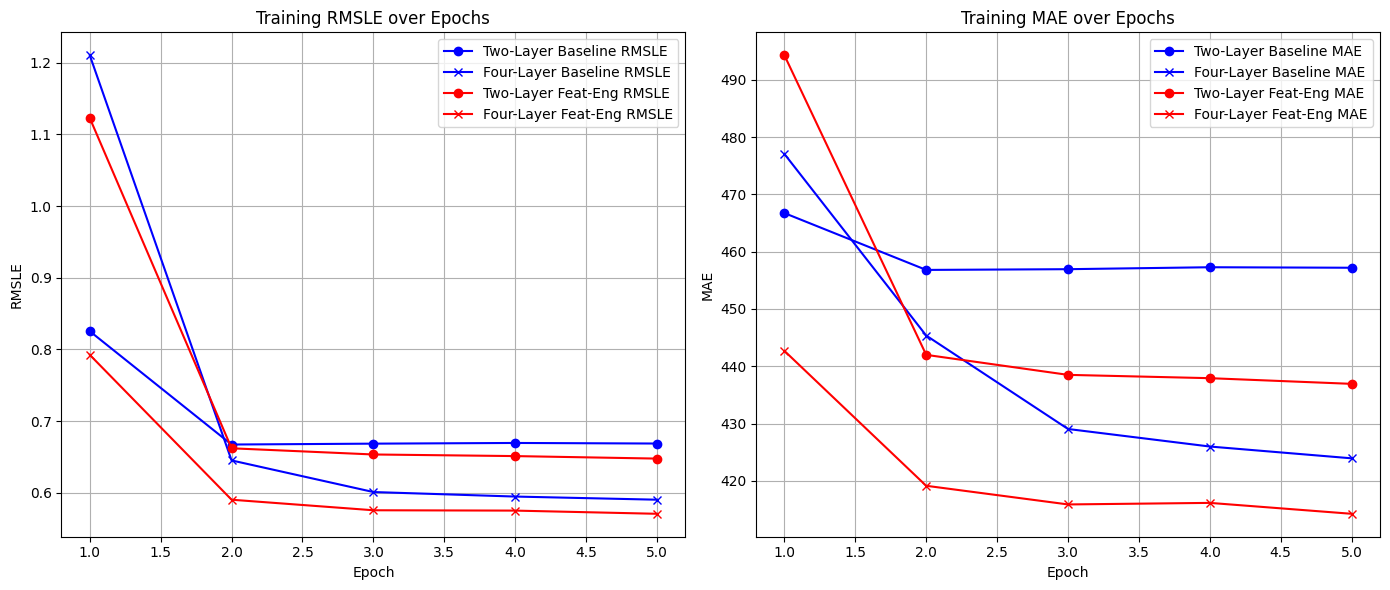

In [202]:
import matplotlib.pyplot as plt

epochs = [e["epoch"] for e in baseline_two_layer_results]

# Extract metrics from baseline_results (2 layer)
rmsle_baseline_two_layer = [e["RMSLE"] for e in baseline_two_layer_results]
mae_baseline_two_layer = [e["MAE"] for e in baseline_two_layer_results]

# Extract metrics from baseline_results (4 layer)
rmsle_baseline_four_layer = [e["RMSLE"] for e in baseline_four_layer_results]
mae_baseline_four_layer = [e["MAE"] for e in baseline_four_layer_results]

# Extract metrics from feature_engineer_results (2 layer)
rmsle_feat_two_layer = [e["RMSLE"] for e in feature_engineer_two_layer_results]
mae_feat_two_layer = [e["MAE"] for e in feature_engineer_two_layer_results]

# Extract metrics from feature_engineer_results (2 layer)
rmsle_feat_four_layer = [e["RMSLE"] for e in feature_engineer_four_layer_results]
mae_feat_four_layer = [e["MAE"] for e in feature_engineer_four_layer_results]

# Create a figure with multiple subplots
plt.figure(figsize=(14, 6))

# Subplot 1: RMSLE
plt.subplot(1, 2, 1)
plt.plot(epochs, rmsle_baseline_two_layer, marker='o', color='blue', label='Two-Layer Baseline RMSLE')
plt.plot(epochs, rmsle_baseline_four_layer, marker='x', color='blue', label='Four-Layer Baseline RMSLE')
plt.plot(epochs, rmsle_feat_two_layer, marker = 'o', color = "red", label = "Two-Layer Feat-Eng RMSLE")
plt.plot(epochs, rmsle_feat_four_layer, marker = 'x', color = "red", label = "Four-Layer Feat-Eng RMSLE")
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.title('Training RMSLE over Epochs')
plt.grid(True)
plt.legend()

# Subplot 2: RMSE, MAE, R²
plt.subplot(1, 2, 2)
plt.plot(epochs, mae_baseline_two_layer, marker='o', color='blue', label='Two-Layer Baseline MAE')
plt.plot(epochs, mae_baseline_four_layer, marker='x', color='blue', label='Four-Layer Baseline MAE')
plt.plot(epochs, mae_feat_two_layer, marker = 'o', color = "red", label = "Two-Layer Feat-Eng MAE")
plt.plot(epochs, mae_feat_four_layer, marker = 'x', color = "red", label = "Four-Layer Feat-Eng MAE")
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Combo Feature Modeling

In [203]:
feature_combinations = {
     "combo_A": [
         'euclid_dist',
         'dir_sin', 'dir_cos',
         'hour', 'weekday',
         'center_cluster_avg_speed',
         'passenger_count',
         'vendor_id'
     ],

    "combo_B": [
        'rot_ns_dist', 'rot_ew_dist',
        'direction_angle',
        'week_hour',
        'pu_cluster_avg_speed', 'do_cluster_avg_speed',
        'passenger_count'
    ],

     "combo_C": [
         'manhattan_dist',
         'dir_bin4',
         'is_rest_day',
         'center_cluster',
         'vendor_id'
     ],

     "combo_D": [
         'distance',
         'dir_bin4',
         'hour_avg_speed',
         'center_cluster',
         'passenger_count'
     ],

    "combo_E": [
        'distance',
        'dir_sin', 'dir_cos',
        'week_hour',
        'center_cluster_avg_speed',
        'pu_cluster_avg_speed',
        'store_and_fwd_flag',
        'passenger_count'
    ],

    "combo_F": [
        'rot_ns_dist', 
        'rot_ew_dist', 
        'pu_cluster_avg_speed', 
        'do_cluster_avg_speed', 
        'passenger_count'
    ]
}

In [204]:
all_results = {}
target = 'trip_duration'

In [205]:
def load_combo(filename, feature_combinations, data_dir="/Users/emiliodulay/Documents/1. UCLA/MATH 156/data"):
    """
    Load a parquet file for a given feature combination and return only the relevant columns.

    Parameters:
    - filename (str): e.g., "combo_A.parquet"
    - feature_combinations (dict): maps combo names to feature lists
    - data_dir (str): folder where parquet files are stored

    Returns:
    - pandas DataFrame with only the specified features
    """
    # Extract combo name (e.g., "combo_A" from "combo_A.parquet")
    combo_name = os.path.splitext(os.path.basename(filename.split(".")[0]))[0]

    if combo_name not in feature_combinations:
        raise ValueError(f"Combo '{combo_name}' not found in feature_combinations.")

    # Load the parquet file
    filepath = os.path.join(data_dir, filename)
    df = pd.read_parquet(filepath)

    # Select only the features specified for this combo
    features = feature_combinations[combo_name]
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features in file {filename}: {missing_features}")

    return df[features]


### Two-Layer Combination Performance

In [206]:
all_results = {}

for combo_name, features in feature_combinations.items():
    print(f"\n=== Running combination: {combo_name} ===")

    df = X_train_adv
    X = df[features].copy()
    y = y_train

    X_tensor = to_tensor(X)
    y_tensor = torch.tensor(y.values.squeeze(), dtype=torch.float32)
    
    train_adv_dataset = MyDataset(X_tensor, y_tensor)
    
    numeric_features = X.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    model = FFNN_simple(input_size=X_tensor.shape[1], output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

    # Initialize a list to store all epoch results for this combo
    all_results[combo_name] = []

    for epoch in range(5):
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            all_preds.append(preds.detach().numpy())
            all_targets.append(yb.detach().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        mse = mean_squared_error(all_targets, all_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

        combo_results = {
            "epoch": epoch + 1,
            "loss": total_loss / len(loader),
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "RMSLE" : rmsle_val
        }

        # Append this epoch's results to the list
        all_results[combo_name].append(combo_results)
        
combo_two_layer_results = all_results




=== Running combination: combo_A ===

=== Running combination: combo_B ===

=== Running combination: combo_C ===

=== Running combination: combo_D ===

=== Running combination: combo_E ===

=== Running combination: combo_F ===


In [207]:
for combo_name, epochs in combo_two_layer_results.items():
    print(f"\n=== Results for {combo_name} ===")
    for epoch_result in epochs:
        print(f"Epoch {epoch_result['epoch']}: "
              f"Loss={epoch_result['loss']:.4f}, "
              f"MSE={epoch_result['MSE']:.4f}, "
              f"RMSE={epoch_result['RMSE']:.4f}, "
              f"MAE={epoch_result['MAE']:.4f}, "
              f"R²={epoch_result['R2']:.4f}")


=== Results for combo_A ===
Epoch 1: Loss=27217376.0558, MSE=27217598.0000, RMSE=5217.0488, MAE=475.7552, R²=0.0078
Epoch 2: Loss=27170083.6808, MSE=27170304.0000, RMSE=5212.5142, MAE=448.3225, R²=0.0095
Epoch 3: Loss=27152387.6608, MSE=27152610.0000, RMSE=5210.8166, MAE=439.5536, R²=0.0101
Epoch 4: Loss=27145731.4528, MSE=27145956.0000, RMSE=5210.1781, MAE=435.5137, R²=0.0104
Epoch 5: Loss=27140531.2501, MSE=27140750.0000, RMSE=5209.6785, MAE=434.5753, R²=0.0106

=== Results for combo_B ===
Epoch 1: Loss=27265405.6050, MSE=27265628.0000, RMSE=5221.6499, MAE=460.3564, R²=0.0060
Epoch 2: Loss=27183251.5765, MSE=27183474.0000, RMSE=5213.7773, MAE=444.0547, R²=0.0090
Epoch 3: Loss=27178835.8547, MSE=27179058.0000, RMSE=5213.3538, MAE=442.7994, R²=0.0092
Epoch 4: Loss=27170347.7634, MSE=27170572.0000, RMSE=5212.5399, MAE=442.5339, R²=0.0095
Epoch 5: Loss=27168394.4742, MSE=27168614.0000, RMSE=5212.3521, MAE=440.6469, R²=0.0096

=== Results for combo_C ===
Epoch 1: Loss=27208469.3508, MSE=

### Four Layer Combination Performance

In [208]:
all_results = {}

for combo_name, features in feature_combinations.items():
    print(f"\n=== Running combination: {combo_name} ===")

    df = X_train_adv
    X = df[features].copy()
    y = y_train

    X_tensor = to_tensor(X)
    y_tensor = torch.tensor(y.values.squeeze(), dtype=torch.float32)
    
    train_adv_dataset = MyDataset(X_tensor, y_tensor)
    
    numeric_features = X.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    model = FFNN_simple(input_size=X_tensor.shape[1], output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

    # Initialize a list to store all epoch results for this combo
    all_results[combo_name] = []

    for epoch in range(5):
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            all_preds.append(preds.detach().numpy())
            all_targets.append(yb.detach().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        mse = mean_squared_error(all_targets, all_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

        combo_results = {
            "epoch": epoch + 1,
            "loss": total_loss / len(loader),
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "RMSLE" : rmsle_val
        }

        # Append this epoch's results to the list
        all_results[combo_name].append(combo_results)
        
combo_four_layer_results = all_results



=== Running combination: combo_A ===

=== Running combination: combo_B ===

=== Running combination: combo_C ===

=== Running combination: combo_D ===

=== Running combination: combo_E ===

=== Running combination: combo_F ===


/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/combo_A.parquet.parquet

In [209]:
for combo_name, epochs in combo_four_layer_results.items():
    print(f"\n=== Results for {combo_name} ===")
    for epoch_result in epochs:
        print(f"Epoch {epoch_result['epoch']}: "
              f"Loss={epoch_result['loss']:.4f}, "
              f"MSE={epoch_result['MSE']:.4f}, "
              f"RMSE={epoch_result['RMSE']:.4f}, "
              f"MAE={epoch_result['MAE']:.4f}, "
              f"R²={epoch_result['R2']:.4f}")



=== Results for combo_A ===
Epoch 1: Loss=27210894.5459, MSE=27211116.0000, RMSE=5216.4275, MAE=474.8524, R²=0.0080
Epoch 2: Loss=27174679.5887, MSE=27174902.0000, RMSE=5212.9552, MAE=455.4984, R²=0.0093
Epoch 3: Loss=27175791.2187, MSE=27176012.0000, RMSE=5213.0617, MAE=451.3176, R²=0.0093
Epoch 4: Loss=27173129.1870, MSE=27173352.0000, RMSE=5212.8065, MAE=450.9839, R²=0.0094
Epoch 5: Loss=27169190.1754, MSE=27169410.0000, RMSE=5212.4284, MAE=450.6779, R²=0.0095

=== Results for combo_B ===
Epoch 1: Loss=27270107.9215, MSE=27270332.0000, RMSE=5222.1003, MAE=467.4656, R²=0.0058
Epoch 2: Loss=27181872.1372, MSE=27182094.0000, RMSE=5213.6450, MAE=445.4279, R²=0.0091
Epoch 3: Loss=27172279.8067, MSE=27172502.0000, RMSE=5212.7250, MAE=444.8773, R²=0.0094
Epoch 4: Loss=27166642.2398, MSE=27166860.0000, RMSE=5212.1838, MAE=444.5711, R²=0.0096
Epoch 5: Loss=27163481.1391, MSE=27163700.0000, RMSE=5211.8807, MAE=444.7669, R²=0.0097

=== Results for combo_C ===
Epoch 1: Loss=27211163.2570, MSE=

In [210]:
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    print(combo_name)
    print(epoch_nums)
    print(epochs)



combo_A
[1, 2, 3, 4, 5]
[{'epoch': 1, 'loss': 27217376.05577806, 'MSE': 27217598.0, 'RMSE': np.float64(5217.048782597303), 'MAE': 475.7552185058594, 'R2': 0.007767677307128906, 'RMSLE': np.float32(0.89217067)}, {'epoch': 2, 'loss': 27170083.680783287, 'MSE': 27170304.0, 'RMSE': np.float64(5212.514172642603), 'MAE': 448.3224792480469, 'R2': 0.009491801261901855, 'RMSLE': np.float32(0.6460094)}, {'epoch': 3, 'loss': 27152387.66078277, 'MSE': 27152610.0, 'RMSE': np.float64(5210.8166346552625), 'MAE': 439.5536193847656, 'R2': 0.010137021541595459, 'RMSLE': np.float32(0.6173257)}, {'epoch': 4, 'loss': 27145731.452805143, 'MSE': 27145956.0, 'RMSE': np.float64(5210.178115957266), 'MAE': 435.513671875, 'R2': 0.010379552841186523, 'RMSLE': np.float32(0.6023797)}, {'epoch': 5, 'loss': 27140531.25014671, 'MSE': 27140750.0, 'RMSE': np.float64(5209.678492959042), 'MAE': 434.5753173828125, 'R2': 0.010569214820861816, 'RMSLE': np.float32(0.59856933)}]
combo_B
[1, 2, 3, 4, 5]
[{'epoch': 1, 'loss': 272

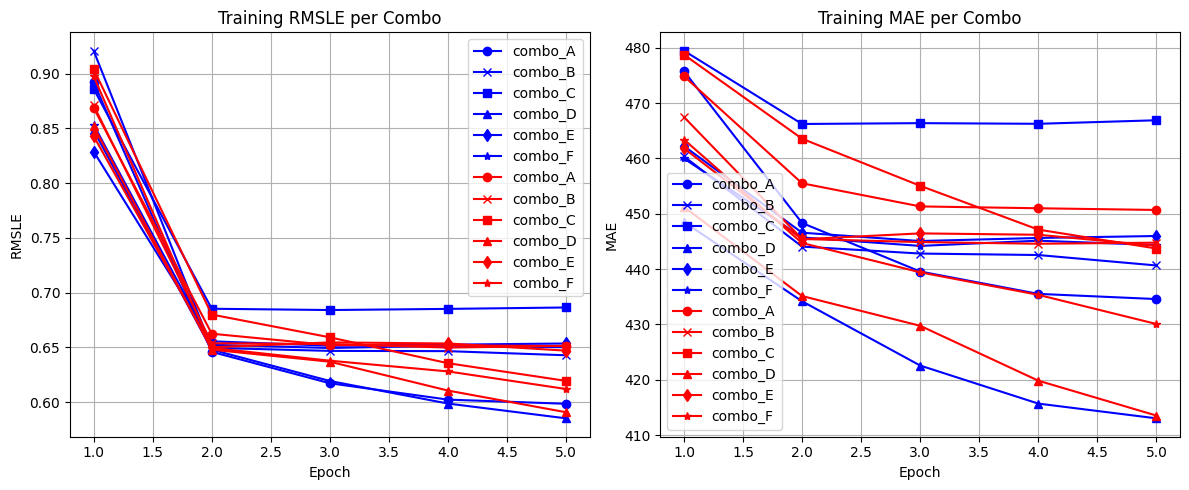

In [213]:
import matplotlib.pyplot as plt
marker = ['o', 'x', 's', '^', 'd', '*']
# Plot Loss and R² over epochs for all combos
plt.figure(figsize=(12, 5))

# Subplot 1: RMSLE
plt.subplot(1, 2, 1)
i = 0
j = 0
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    rmsle_two_layer_combo = [e['RMSLE'] for e in epochs]
    plt.plot(epoch_nums, rmsle_two_layer_combo, marker=marker[i], label=combo_name, color = "blue")
    i += 1
for combo_name, epochs in combo_four_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    RMSLE_four_layer_combo = [e['RMSLE'] for e in epochs]
    plt.plot(epoch_nums, RMSLE_four_layer_combo, marker= marker[j], label=combo_name, color = "red")
    j += 1
    
plt.xlabel("Epoch")
plt.ylabel("RMSLE")
plt.title("Training RMSLE per Combo")
plt.legend()
plt.grid(True)

# Subplot 2: MAE
plt.subplot(1, 2, 2)
i = 0
j = 0   
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    MAE_two_layer_combo = [e['MAE'] for e in epochs]
    plt.plot(epoch_nums, MAE_two_layer_combo, marker=marker[i], label=combo_name, color = "blue")
    i += 1
for combo_name, epochs in combo_four_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    MAE_four_layer_combo = [e['MAE'] for e in epochs]
    plt.plot(epoch_nums, MAE_four_layer_combo, marker=marker[j], label=combo_name, color = "red")
    j += 1
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training MAE per Combo")
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.show()


In [217]:
for k in range(len(marker)):
    print(k)

0
1
2
3
4
5


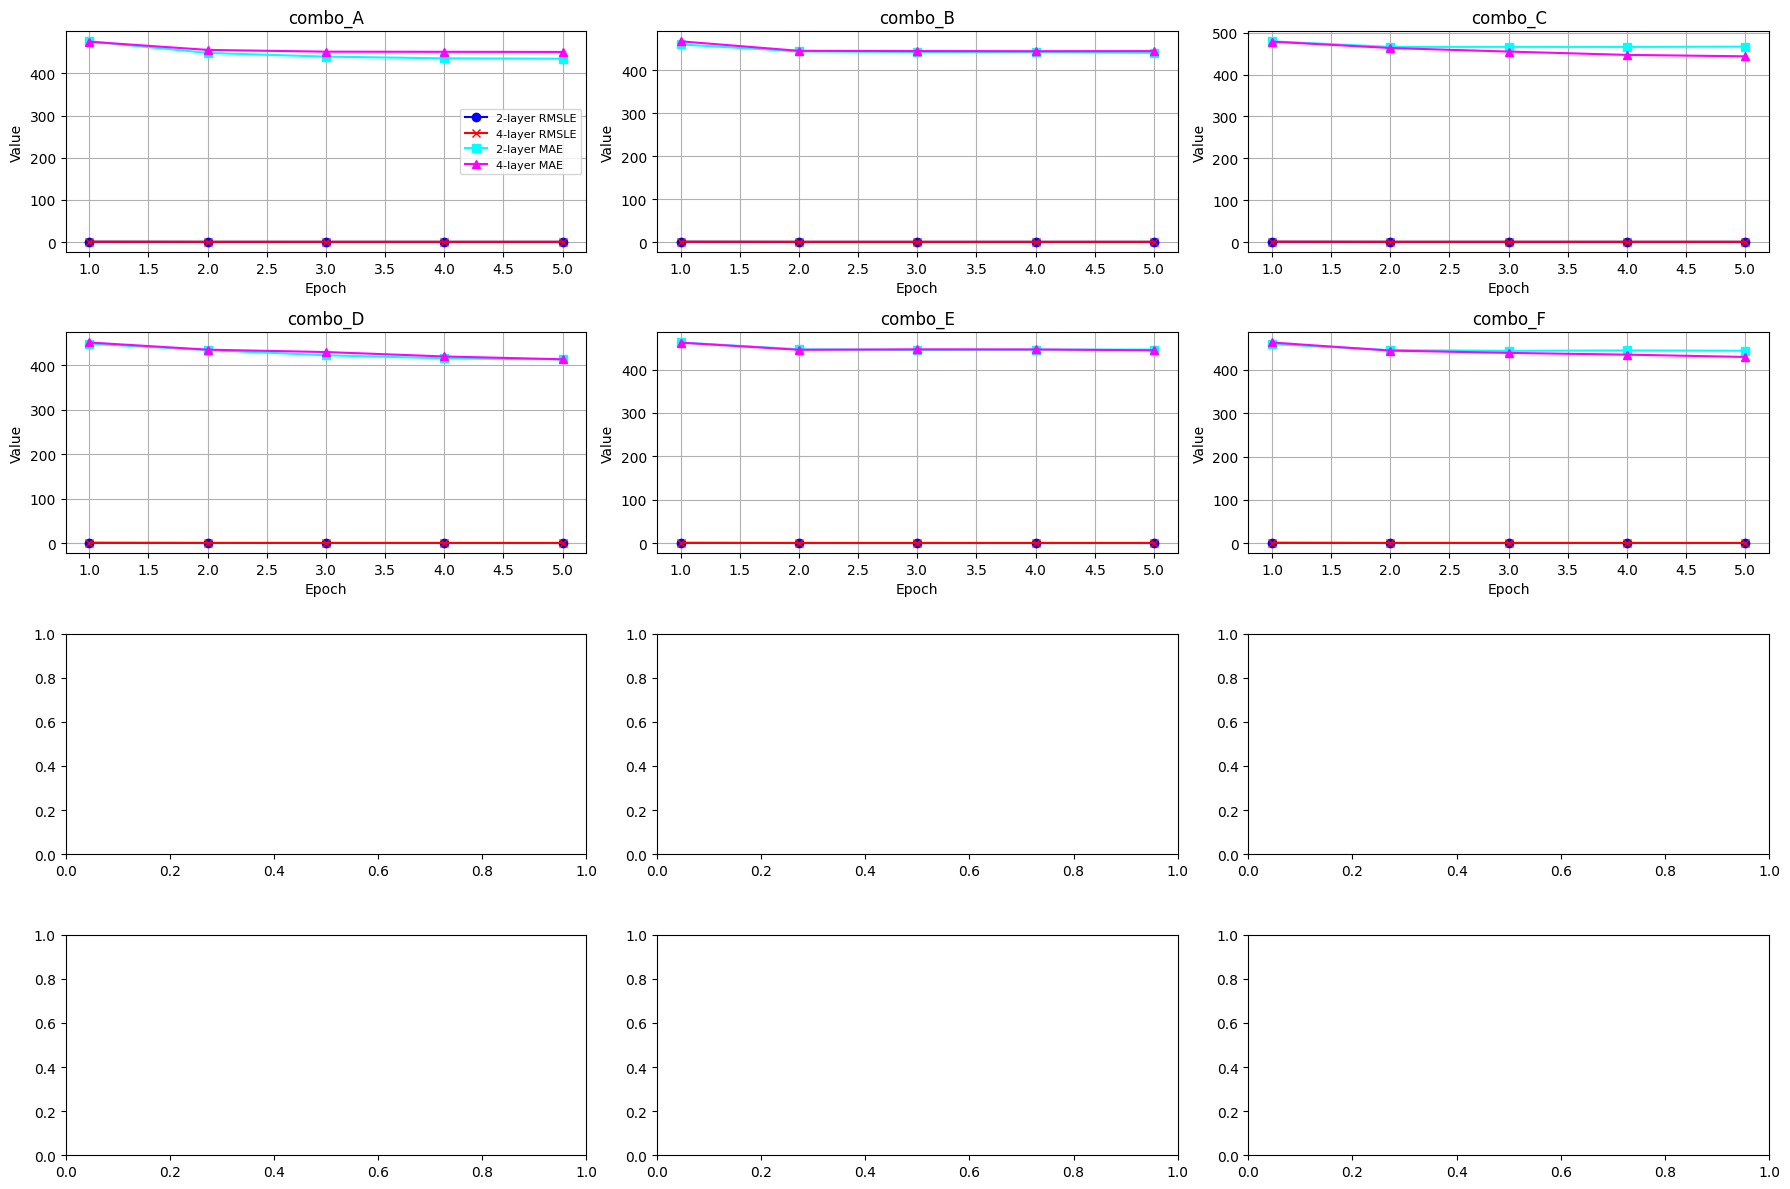

In [218]:
import matplotlib.pyplot as plt

marker = ['o', 'x', 's', '^', 'd', '*', 'v', '<', '>', '1', '2', '3']  # enough markers for 12 combos

combos = list(combo_two_layer_results.keys())  # assuming both dicts have same keys
n_combos = len(combos)

fig, axes = plt.subplots(4, 3, figsize=(18, 12))  # 4 rows x 3 cols

for idx, combo_name in enumerate(combos):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Plot RMSLE
    epochs_two = [e['epoch'] for e in combo_two_layer_results[combo_name]]
    rmsle_two = [e['RMSLE'] for e in combo_two_layer_results[combo_name]]
    ax.plot(epochs_two, rmsle_two, marker='o', color='blue', label='2-layer RMSLE')
    
    epochs_four = [e['epoch'] for e in combo_four_layer_results[combo_name]]
    rmsle_four = [e['RMSLE'] for e in combo_four_layer_results[combo_name]]
    ax.plot(epochs_four, rmsle_four, marker='x', color='red', label='4-layer RMSLE')
    
    # Plot MAE
    mae_two = [e['MAE'] for e in combo_two_layer_results[combo_name]]
    ax.plot(epochs_two, mae_two, marker='s', color='cyan', label='2-layer MAE')
    
    mae_four = [e['MAE'] for e in combo_four_layer_results[combo_name]]
    ax.plot(epochs_four, mae_four, marker='^', color='magenta', label='4-layer MAE')
    
    ax.set_title(combo_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.grid(True)
    
    if idx == 0:
        ax.legend(fontsize=8)  # only show legend on first subplot for readability

plt.tight_layout()
plt.show()


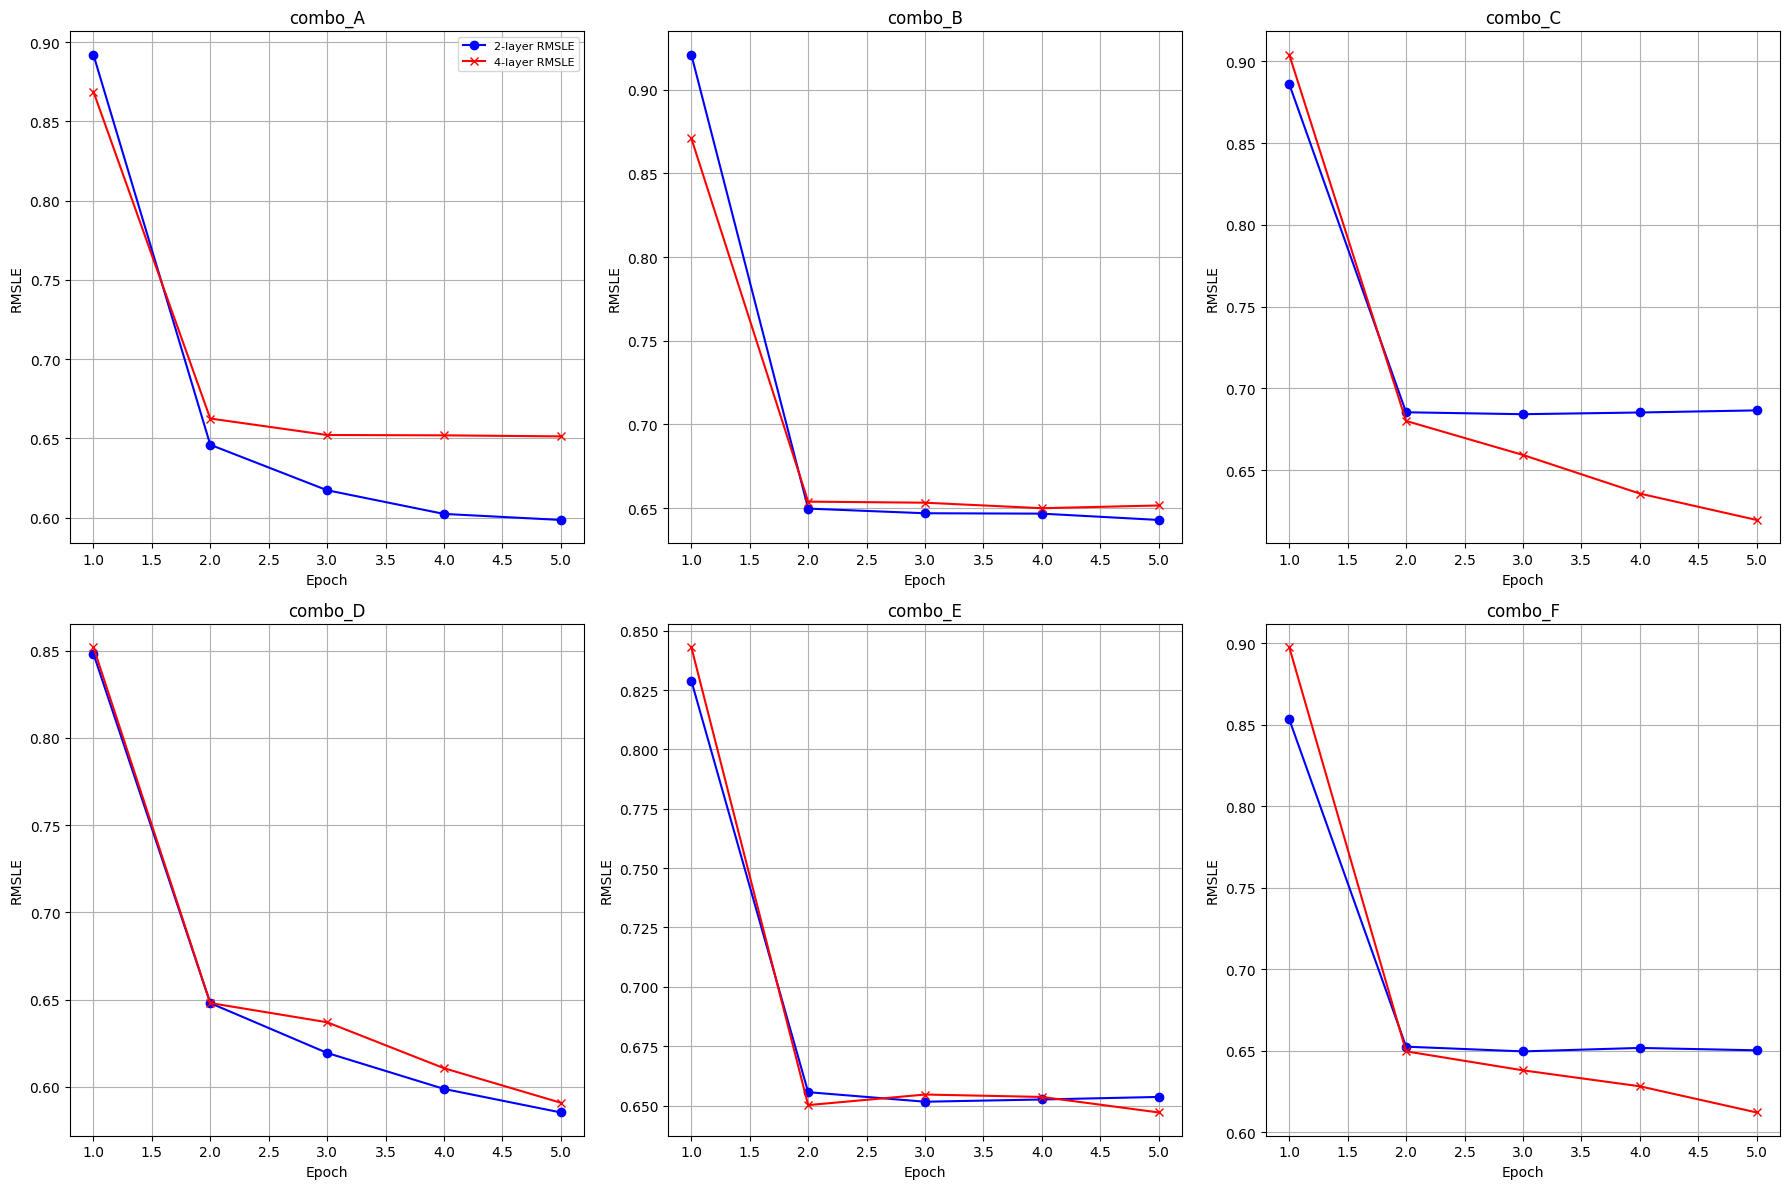

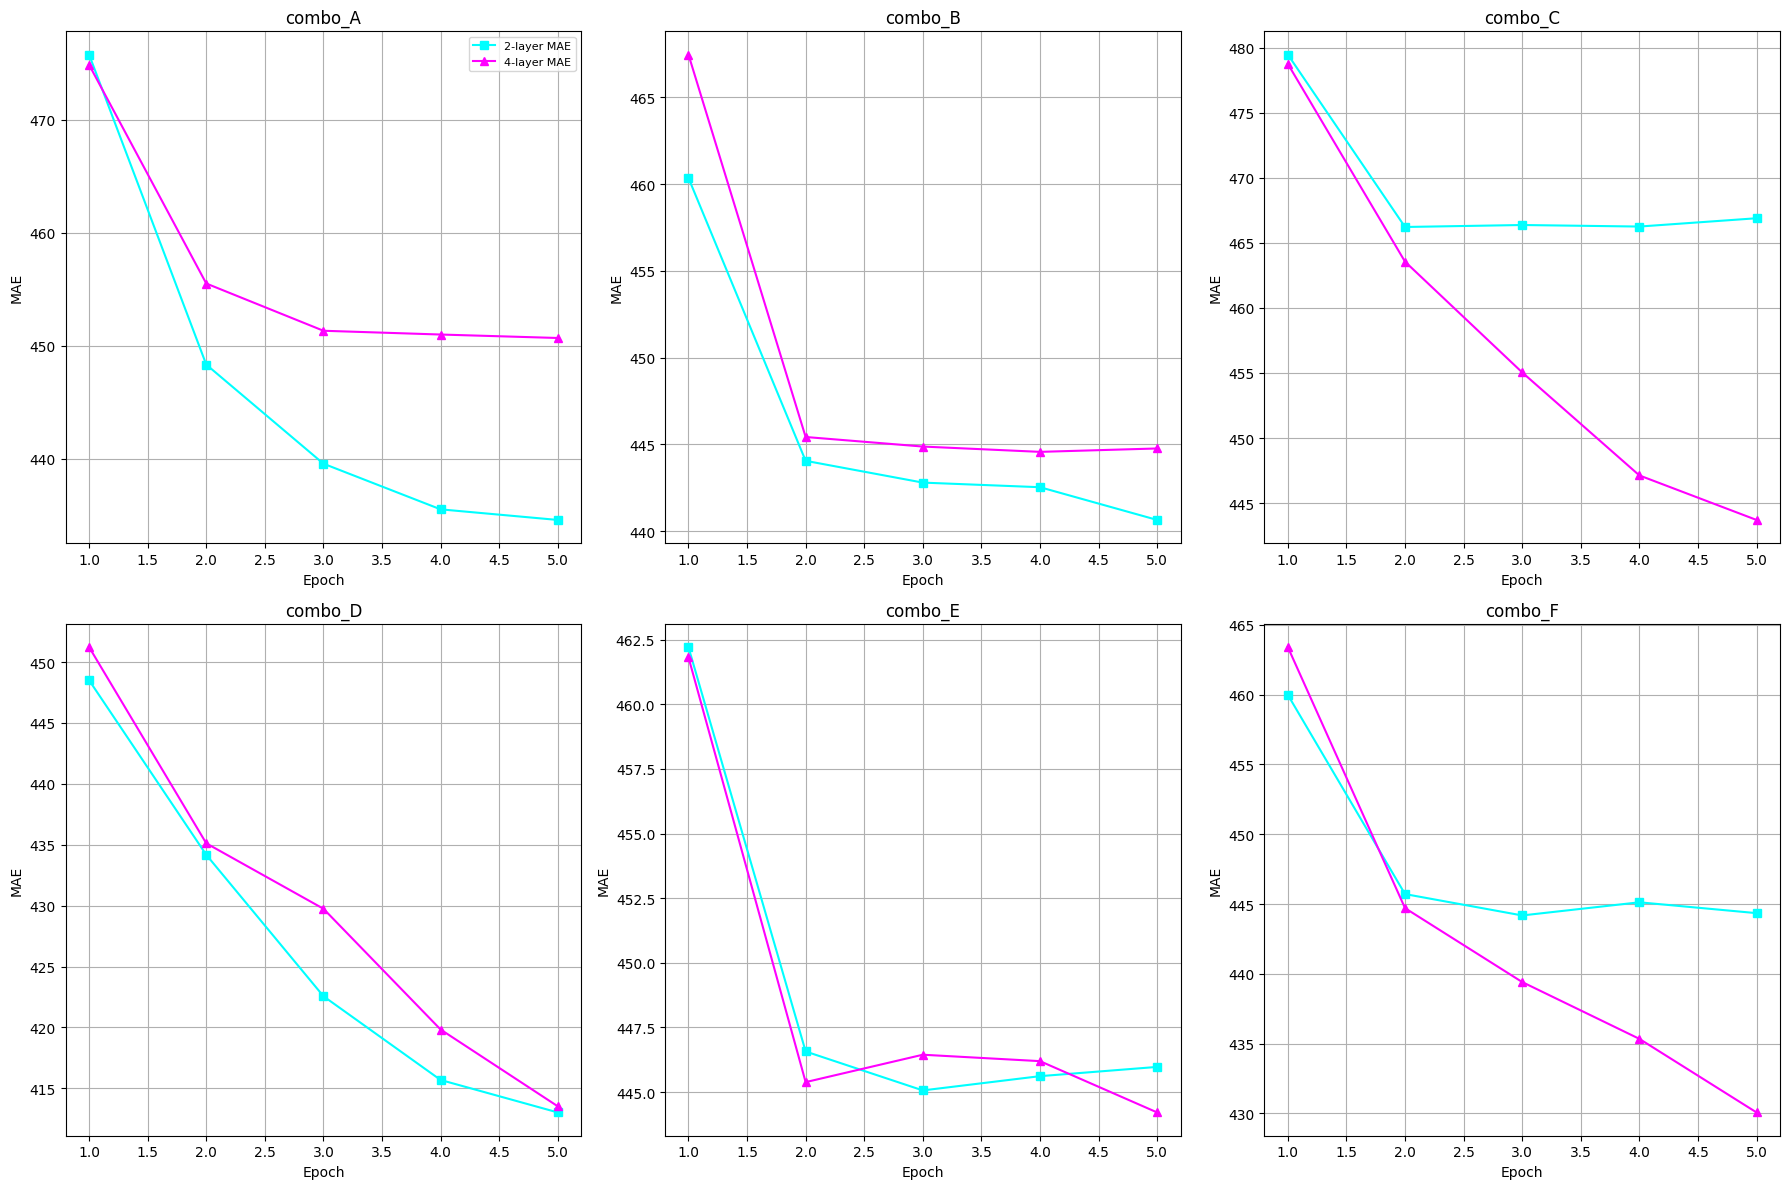

In [220]:
import matplotlib.pyplot as plt

marker = ['o', 'x', 's', '^', 'd', '*', 'v', '<', '>', '1', '2', '3']  # markers for combos
combos = list(combo_two_layer_results.keys())
n_combos = len(combos)

# ---- RMSLE plots ----
fig_rmsle, axes_rmsle = plt.subplots(2, 3, figsize=(18, 12))

for idx, combo_name in enumerate(combos):
    row = idx // 3
    col = idx % 3
    ax = axes_rmsle[row, col]
    
    epochs_two = [e['epoch'] for e in combo_two_layer_results[combo_name]]
    rmsle_two = [e['RMSLE'] for e in combo_two_layer_results[combo_name]]
    ax.plot(epochs_two, rmsle_two, marker='o', color='blue', label='2-layer RMSLE')
    
    epochs_four = [e['epoch'] for e in combo_four_layer_results[combo_name]]
    rmsle_four = [e['RMSLE'] for e in combo_four_layer_results[combo_name]]
    ax.plot(epochs_four, rmsle_four, marker='x', color='red', label='4-layer RMSLE')
    
    ax.set_title(combo_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSLE")
    ax.grid(True)
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ---- MAE plots ----
fig_mae, axes_mae = plt.subplots(2, 3, figsize=(18, 12))

for idx, combo_name in enumerate(combos):
    row = idx // 3
    col = idx % 3
    ax = axes_mae[row, col]
    
    epochs_two = [e['epoch'] for e in combo_two_layer_results[combo_name]]
    mae_two = [e['MAE'] for e in combo_two_layer_results[combo_name]]
    ax.plot(epochs_two, mae_two, marker='s', color='cyan', label='2-layer MAE')
    
    epochs_four = [e['epoch'] for e in combo_four_layer_results[combo_name]]
    mae_four = [e['MAE'] for e in combo_four_layer_results[combo_name]]
    ax.plot(epochs_four, mae_four, marker='^', color='magenta', label='4-layer MAE')
    
    ax.set_title(combo_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MAE")
    ax.grid(True)
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
